In [1]:
import CentralStreamingModel.comparisons.models as md
import pickle
import matplotlib.pyplot as plt
import numpy as np
import importlib
import seaborn as sns
from CentralStreamingModel.utils import plot_tools as pt
sns.set_context('talk')
import time
from scipy.optimize import curve_fit

In [2]:
lamda = 0.6844
matter = 1. - lamda


v = 20 * (1 + 0.5)**0.5/((1+0.5)**3*matter + lamda)
print(v)

14.000684420469137


In [3]:
n_boxes = range(1,15)
boxsize = 2000
snapshot = 11

rs = []
for i, box in enumerate(n_boxes):
    rs.append(md.RedshiftSpace(box, boxsize, snapshot))

In [4]:
import importlib
importlib.reload(md)

<module 'CentralStreamingModel.comparisons.models' from '/home/c-cuesta/CentralStreamingModel/comparisons/models.py'>

In [5]:
t1 = time.time()
mean_rs = md.MeanRedshiftSpace( boxsize, snapshot, rs)
print(f'It took {time.time() - t1} seconds.')

It took 38.83000063896179 seconds.


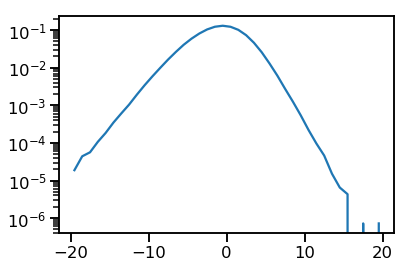

In [13]:
plt.semilogy(mean_rs.per_box_list[0].measured.v_los,
         mean_rs.measured.jointpdf_los.mean[20,20,:])

Text(0, 0.5, '$s_\\parallel$ [Mpc/h]')

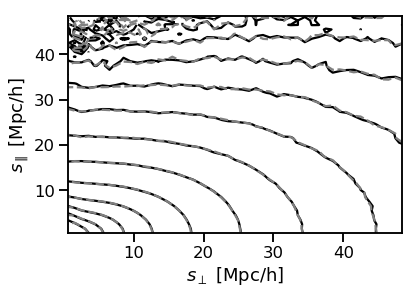

In [14]:
s_c = rs[0].measured.s_c
levels = np.arange(-4, 1, 0.3)


colors = [mean_rs.measured.color] * len(levels)
plt.contour(s_c, s_c, 
            np.log10(mean_rs.measured.pi_sigma.mean).T, 
            levels=levels, colors=colors)

colors = [mean_rs.streaming.color] * len(levels)
plt.contour(mean_rs.streaming.s_c, mean_rs.streaming.s_c,
            np.log10(mean_rs.streaming.pi_sigma).T,
           levels=levels, colors=colors, linestyles='dashed')

#colors = [mean_rs.gaussian.color] * len(levels)

#plt.contour(mean_rs.gaussian.s_c, mean_rs.gaussian.s_c,
#            np.log10(mean_rs.gaussian.pi_sigma).T,
#           levels=levels, colors=colors)


#plt.xlim(0,30)

#plt.ylim(0,30)

plt.xlabel('$s_\perp$ [Mpc/h]')
plt.ylabel('$s_\parallel$ [Mpc/h]')

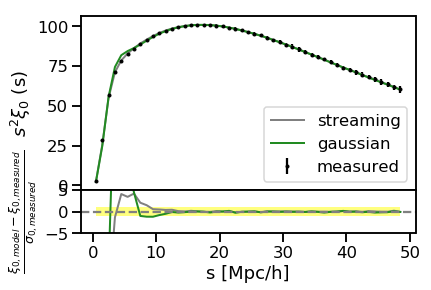

In [15]:
pt.plot_attribute_residual( mean_rs, ['streaming', 'gaussian'],
                    'monopole',  r'$s^2\xi_0$ (s)', 
                           r'$\frac{\xi_{0,model} - \xi_{0, measured}}{\sigma_{0, measured}}$')


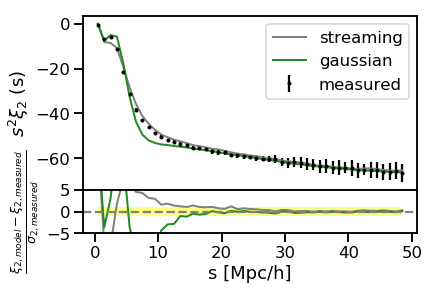

In [16]:
pt.plot_attribute_residual( mean_rs, ['streaming', 'gaussian'],
                    'quadrupole', r'$s^2\xi_2$ (s)',
        r'$\frac{\xi_{2,model} - \xi_{2, measured}}{\sigma_{2, measured}}$')

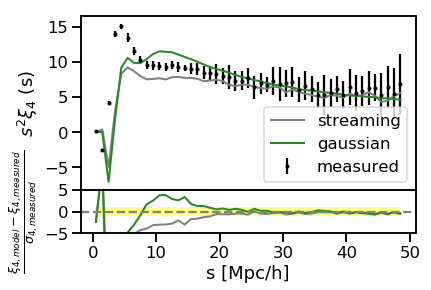

In [17]:
pt.plot_attribute_residual( mean_rs, ['streaming', 'gaussian'],
                    'hexadecapole', r'$s^2\xi_4$ (s)',
        r'$\frac{\xi_{4,model} - \xi_{4, measured}}{\sigma_{4, measured}}$')


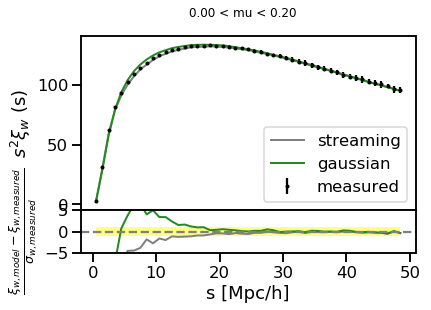

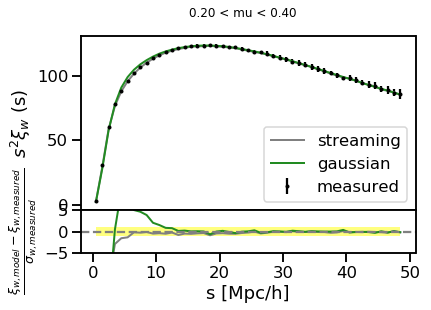

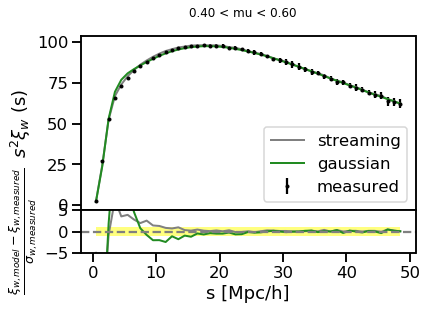

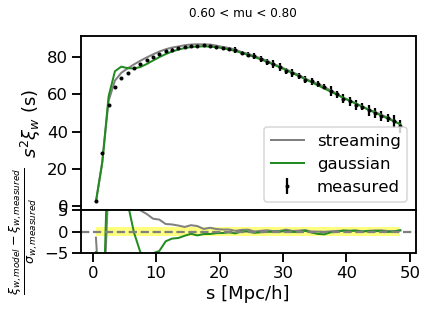

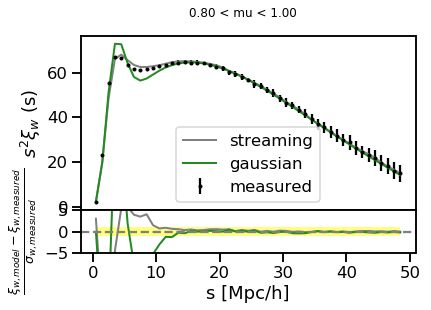

In [12]:
n_wedges = 5

for wedge in range(n_wedges):
    
    pt.plot_attribute_residual( mean_rs, ['streaming', 'gaussian'],
                    f'wedge_{wedge}', r'$s^2\xi_w$ (s)',
        r'$\frac{\xi_{w,model} - \xi_{w, measured}}{\sigma_{w, measured}}$',
        title =f'{mean_rs.streaming.wedges_bins[wedge]:.2f} < mu < {mean_rs.streaming.wedges_bins[wedge+1]:.2f}' )
    plt.show()

In [ ]:
def gauss(x,x0,sigma):
    return 1./np.sqrt(2 * np.pi)/sigma * np.exp(-(x-x0)**2/(2*sigma**2))

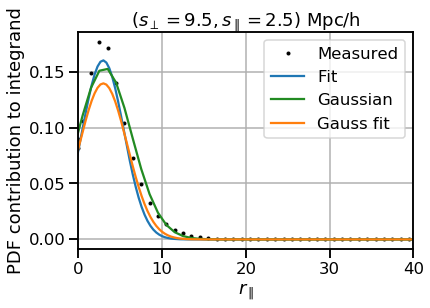

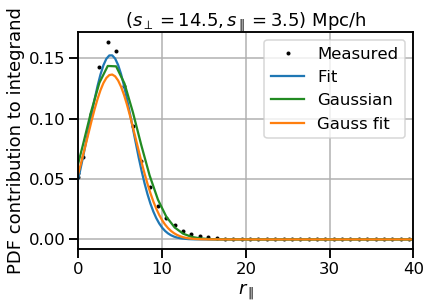

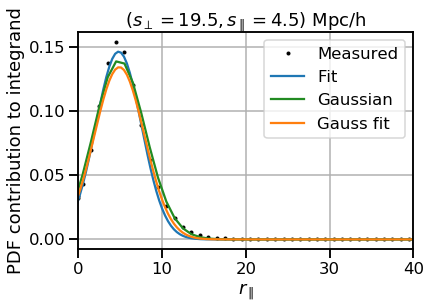

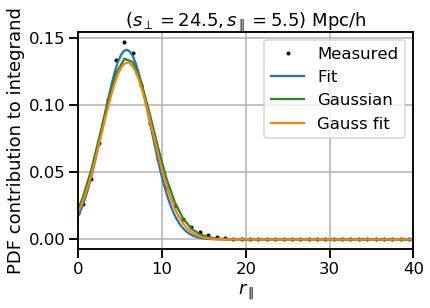

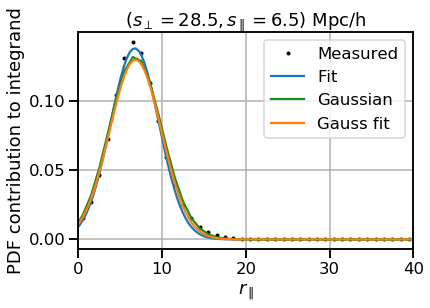

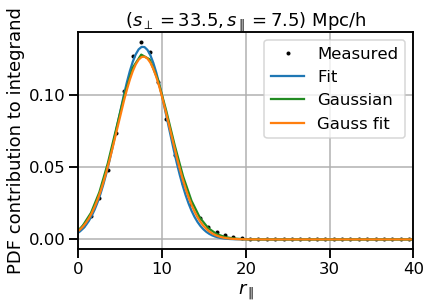

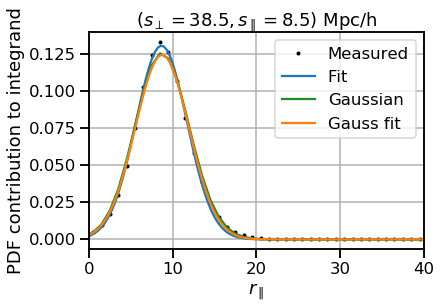

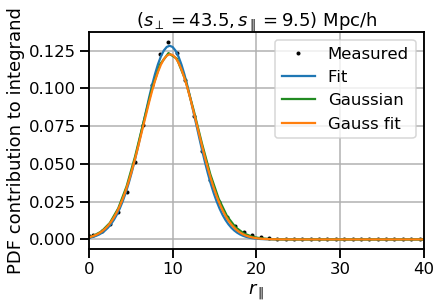

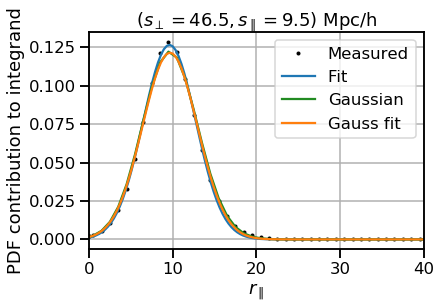

In [113]:
s_list = [10,15,20,25,30,35,40,45,48]
mu = 0.2
r_fit = np.linspace(-70,70,400)
sigma_measured = []
sigma_gauss = []
for s in s_list:
    rperp = int(s * (1 - mu**2))
    rparal = int(s * mu)


    popt,pcov = curve_fit(gauss,
                          mean_rs.streaming.int_r_parallel,
                          mean_rs.streaming.pdf_contribution[rperp,rparal],
                          p0=[0.,10])

    popt_gauss,pcov_gauss = curve_fit(gauss,
                          mean_rs.gaussian.int_r_parallel,
                          mean_rs.gaussian.pdf_contribution[rperp,rparal],
                          p0=[0.,10])
    
    sigma_measured.append(popt[-1])

    sigma_gauss.append(popt_gauss[-1])

    plt.title(r'($ s_\perp = %.1f'
                   ', s_\parallel = %.1f)$ Mpc/h'%(rs[0].measured.r_perp[rperp],
                                                   rs[0].measured.r_parallel[rparal]))

    plt.plot(mean_rs.streaming.int_r_parallel,
            mean_rs.streaming.pdf_contribution[rperp,rparal], 
            linestyle='', marker='o',
            markersize=3, color='k', label='Measured')
    plt.plot(r_fit, gauss(r_fit, *popt), label='Fit')


    #plt.plot(mean_rs.streaming.int_r_parallel, norm.pdf(mean_rs.streaming.int_r_parallel,
    #                                    loc = s*mu + 0.3, scale = 3.7))
    plt.plot(mean_rs.gaussian.int_r_parallel,
            mean_rs.gaussian.pdf_contribution[rperp,rparal], 
            linestyle='-',
                color= mean_rs.gaussian.color, label='Gaussian')
    plt.plot(r_fit, gauss(r_fit, *popt_gauss), label='Gauss fit')


    plt.xlim(0, 40)
    plt.legend(bbox_to_anchor = [1.,1.])
    plt.xlabel('$r_\parallel$')
    plt.ylabel('PDF contribution to integrand')
    plt.grid()
    plt.show()



In [114]:
sigma_gauss = np.asarray(sigma_gauss)

In [115]:
m, n = np.poly1d(np.polyfit(s_list, sigma_gauss, 1))

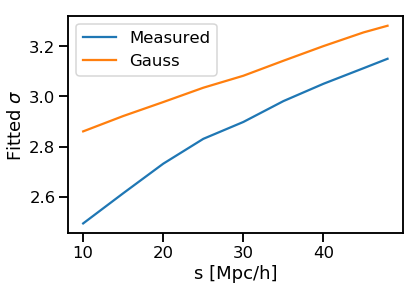

In [116]:
plt.plot(s_list, sigma_measured, label = 'Measured') 
plt.plot(s_list, sigma_gauss, label= 'Gauss') 
s_list = np.asarray(s_list)
#plt.plot(s_list, m * s_list + n)
plt.xlabel('s [Mpc/h]')
plt.ylabel('Fitted $\sigma$')
plt.legend()

In [47]:
from scipy.interpolate import interp1d
std_r = interp1d(mean_rs.per_box_list[0].measured.r,
        mean_rs.measured.std_r.mean, kind='linear', bounds_error = False,
                    fill_value = (mean_rs.measured.std_r.mean[0], mean_rs.measured.std_r.mean[-1]))
std_t = interp1d(mean_rs.per_box_list[0].measured.r,
            mean_rs.measured.std_t.mean, kind='linear', bounds_error = False,
                    fill_value = (mean_rs.measured.std_t.mean[0], mean_rs.measured.std_t.mean[-1]))


In [48]:
r_test = np.arange(0.5,99.5,1)
prefactor = r_test**2/(r_test**2 + rperp**2)

sigma_parallel = prefactor * std_r(np.sqrt(r_test**2 + rperp**2))**2 + \
     (1 - prefactor**2) * std_t(np.sqrt(r_test**2 + rperp**2))**2


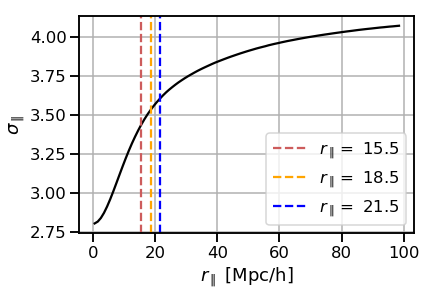

In [49]:
plt.plot(r_test, np.sqrt(sigma_parallel), color='black')
plt.xlabel('$r_\parallel$ [Mpc/h]')
plt.ylabel('$\sigma_\parallel$')
check_r_parallel = [15.5,18.5,21.5]
colors = ['indianred', 'orange','blue', 'purple', 'gray', 'green']
for i, crp in enumerate(check_r_parallel):
    v_los = mean_rs.per_box_list[0].measured.v_los
    plt.axvline(x = np.abs(crp),
               color = colors[i], linestyle='dashed', label = f'$r_\parallel = $ {crp}')
plt.legend()
plt.grid(which='both')